# <strong> Example parameterised cradle-to-gate life cycle assessment: </strong> <br>
# <strong> Linking BatPaC to Brightway </strong>

Following notebook provides three examples of the linkages between BatPaC to Brightway2 to calculate the cradle-to-gate life cycle emissions of different battery designs.


* [Example 1: Cradle to gate emission of a single battery design](#first-bullet)
* [Example 2: Cradle to gate emission  of several battery design](#second-bullet)
* [Example 3: Cradle to gate emission  of several battery design modular approach](#third-bullet)



<center><img src='../docs/batpac_bw_link.jpg' width=800/></center>

In [1]:
#Import required packages

import brightway2 as bw
import numpy as np
import pandas as pd
import openpyxl
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group, ParameterManager
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 10Feb2022.xlsm"#ADD PATH


# Example 1 - Cradle-to-gate of a single battery <a class="anchor" id="first-bullet"></a>




## Solve battery system in BatPaC:
First, the material content of a single battery is obtained. The design of the Volkswagen MEB platform, 77 kWh version as reported by
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example (NMC622 is used instead of NMC712, as the latter is not in the public version of BatPaC V5l). All other parameters are BatPaC default parameters.

* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Modules in parallel: 2 
* Maximum charging time: 33 minutes (ev-database.org)
* Maximum charge power: 135 kW (ev-database.org)
<br>

<!-- <a href=https://www.volkswagen-newsroom.com/en/press-releases/long-range-and-rapid-charging-the-battery-system-is-at-the-heart-of-the-volkswagen-id3-id4-and-id4-gtx-7130>
<center><img src='../docs/ID pack.jpg' width=600/> <br></center>
<figcaption align = "center"><b>Structure of the Volkswagen MEB platform (VW, 2021) </b></figcaption>
</a> -->

In [2]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                             vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 34,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             max_charge_power = 126,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

In [3]:
# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=False)

## Import Brightway databases
Brightway databases are imported containing parameterised inventories and default project parameters:


In [142]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()
    
#Battery LCA setup:
# Import all Brightway2 databases (BW2Package format) required for the battery LCA: 
bat_lca.import_db_brightway()

# Import the default supply chain parameters such as process yield and energy consumption (see Excel file: '2_lca_lcc_module/data/bw_default_project_parameters.xlsx' ):
bat_lca.import_project_parameters()

# # Import the BW activity functions CHECK IF NEEDED IF THE BW2PACKAGES ARE UPLOADED!!!!
# df_act_functions = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\bw_activity_functions.xlsx", sheet_name = 'activity_functions')

# bat_lca.import_activity_functions (df_act_functions)

Biosphere database already present!!! No setup is needed
anode_material  already present
anode_materials  already present
battery_production  already present
cathode  already present
cathode_material  already present
cell_container  already present
cell_other  already present
current_collectors  already present
cut_off_materials  already present
cut_off_materials  already present
cut_off_production  already present
electrolyte  already present
manufacturing_waste_scrap  already present
module  already present
MyModelName  already present
other_material  already present
other_materials  already present
pack  already present
separator  already present
separators  already present


All battery production activities contain formulas with Brightway project parameters. 
 <br>For example, the activity "mixing cathode materials" in the "battery_production" database contains the following exchanges, formulas and default amounts:

In [146]:
act_cat_mixing = [act for act in bw.Database('battery_production') if act['name']=='mixing cathode materials'][0] 
input = [bw.get_activity(exc['input'])['reference product'] for exc in act_cat_mixing.exchanges()]
formula = [exc['formula'] for exc in act_cat_mixing.exchanges()]
amount = [round(exc['amount'], 2) for exc in act_cat_mixing.exchanges()]
unit = [bw.get_activity(exc['input'])['unit'] for exc in act_cat_mixing.exchanges()]
df_cath_mixing = pd.DataFrame()
df_cath_mixing[['Input product', 'Activity formula', 'Default amount', 'Unit']] = np.array([input, formula, amount, unit]).T
pd.options.display.max_colwidth = 100
df_cath_mixing

,Input product,Activity formula,Default amount,Unit
0,cathode slurry,cathode_slurry,221.38,kilogram
1,binder solvent (NMP),(binder_solvent_nmp/py_am_mixing_total)-binder_solvent_recovered,1.08,kilogram
2,cathode active material (LFP),cathode_active_material_lfp/py_am_mixing_total,0.0,kilogram
3,cathode active material (LMO),cathode_active_material_lmo/py_am_mixing_total,0.0,kilogram
4,cathode active material (NCA),cathode_active_material_nca/py_am_mixing_total,0.0,kilogram
5,cathode active material (NMC333),cathode_active_material_nmc333/py_am_mixing_total,0.0,kilogram
6,cathode active material (NMC532),cathode_active_material_nmc532/py_am_mixing_total,0.0,kilogram
7,cathode active material (NMC622),cathode_active_material_nmc622/py_am_mixing_total,145.05,kilogram
8,cathode active material (NMC811),cathode_active_material_nmc811/py_am_mixing_total,0.0,kilogram
9,cathode binder (PVDF),cathode_binder_pvdf/py_am_mixing_total,3.02,kilogram


## Update Brightway project parameters
The battery design outputs are used as change the project parameters in Brightway and update the activities amounts accordingly

In [144]:
#Change BatPaC output to Brightway project names (non-alphanumeric keys)
battery_design_param = bat_lca.output_as_bw_param(result_dict)
battery_design_param

{'anode_active_material_sio': 0.0,
 'anode_active_material_natural_graphite': 0,
 'anode_active_material_synthetic_graphite': 76.71770113189974,
 'anode_binder_cmc': 0.9394004220232621,
 'anode_binder_additive_sbr': 0.6262669480155081,
 'anode_carbon_black': 0.0,
 'anode_current_collector_cu_10um': 18.194443162372977,
 'anode_current_collector_cu_11um': 0,
 'anode_current_collector_cu_12um': 0,
 'anode_current_collector_cu_13um': 0,
 'anode_current_collector_cu_14um': 0,
 'anode_current_collector_cu_6um': 0,
 'anode_current_collector_cu_7um': 0,
 'anode_current_collector_cu_8um': 0,
 'anode_current_collector_cu_9um': 0,
 'battery_jacket': 78.04981608120335,
 'battery_jacket_al': 28.65235247996749,
 'battery_jacket_fe': 47.89237197752096,
 'battery_jacket_insulation': 1.5050916237148981,
 'battery_management_system': 3.5776000000000003,
 'battery_pack': 544.934753354841,
 'busbar': 0.0,
 'cathode_active_material_50_50_nmc532_lmo': 0,
 'cathode_active_material_lfp': 0,
 'cathode_active_m

In [147]:
#Update the project parameters and recalculate activity amounts in Brightway:
bat_lca.update_param_battery_bw(battery_design_param)
amount_updated = [round(exc['amount'], 2) for exc in act_cat_mixing.exchanges()]
df_cath_mixing.insert(3, 'Updated amount', pd.DataFrame(amount_updated)) 
df_cath_mixing


,Input product,Activity formula,Default amount,Updated amount,Unit
0,cathode slurry,cathode_slurry,221.38,221.38,kilogram
1,binder solvent (NMP),(binder_solvent_nmp/py_am_mixing_total)-binder_solvent_recovered,1.08,1.08,kilogram
2,cathode active material (LFP),cathode_active_material_lfp/py_am_mixing_total,0.0,0.00,kilogram
3,cathode active material (LMO),cathode_active_material_lmo/py_am_mixing_total,0.0,0.00,kilogram
4,cathode active material (NCA),cathode_active_material_nca/py_am_mixing_total,0.0,0.00,kilogram
5,cathode active material (NMC333),cathode_active_material_nmc333/py_am_mixing_total,0.0,0.00,kilogram
6,cathode active material (NMC532),cathode_active_material_nmc532/py_am_mixing_total,0.0,0.00,kilogram
7,cathode active material (NMC622),cathode_active_material_nmc622/py_am_mixing_total,145.05,145.05,kilogram
8,cathode active material (NMC811),cathode_active_material_nmc811/py_am_mixing_total,0.0,0.00,kilogram
9,cathode binder (PVDF),cathode_binder_pvdf/py_am_mixing_total,3.02,3.02,kilogram


## Calculate environmental impacts in Brightway

In [128]:
lcia_results = {}

#Calculate emissions for all ReCiPe midpoint V.1.13
methods = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method)]

# Set up LCI in Brightway with total pack weight as function unit:
battery_production =bw.Database('battery_production').get(('025dcd4c91fc4eeda276f5fff9ad198e_copy5'))
fu = {battery_production: battery_design_param['battery_pack']}
pack_lca = bw.LCA(fu, methods[0])
pack_lca.lci()
pack_lca.lcia()

# Calculate scores:
for impact_category in methods:
    pack_lca.switch_method(impact_category)
    pack_lca.lcia()
    lcia_results [impact_category] = {}
    lcia_results [impact_category]['score'] = pack_lca.score
    lcia_results [impact_category]['unit'] = bw.Method(impact_category).metadata['unit']

In [197]:
df_total = pd.DataFrame.from_dict(lcia_results).T
df_impact_single = pd.DataFrame()
df_impact_single['score pack'] = df_total['score'].astype(float).round(2)
df_impact_single['score kWh'] = (df_total['score']/battery_design_param['battery_capacity']).astype(float).round(4)
df_impact_single['score kg'] = (df_total['score'].astype(float).round(2)/battery_design_param['battery_pack']).astype(float).round(4)
df_impact_single['unit'] = df_total['unit'] 
df_impact_single


score pack  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP        10363.75   
                                agricultural land occupation    ALOP         336.44   
                                climate change                  GWP100      6613.83   
                                fossil depletion                FDP         2156.20   
                                freshwater ecotoxicity          FETPinf       20.21   
                                freshwater eutrophication       FEP            0.41   
                                human toxicity                  HTPinf      1879.70   
                                ionising radiation              IRP_HE       721.20   
                                marine ecotoxicity              METPinf       28.96   
                                marine eutrophication           MEP            3.13   
                                natural land transformation     NLTP          -1.13   
                                ozone depletion                 ODPinf         0.00   
                                particulate matter formation    PMFP          20.80   
                                photochemical oxidant formation POFP          26.75   
                                terrestrial acidification       TAP100        54.66   
                                terrestrial ecotoxicity         TETPinf        2.11   
                                urban land occupation           ULOP         105.09   
                                water depletion                 WDP          485.66   

                                                                         score kWh  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP       116.6502   
                                agricultural land occupation    ALOP        3.7868   
                                climate change                  GWP100     74.4426   
                                fossil depletion                FDP        24.2694   
                                freshwater ecotoxicity          FETPinf     0.2275   
                                freshwater eutrophication       FEP         0.0046   
                                human toxicity                  HTPinf     21.1572   
                                ionising radiation              IRP_HE      8.1176   
                                marine ecotoxicity              METPinf     0.3260   
                                marine eutrophication           MEP         0.0352   
                                natural land transformation     NLTP       -0.0127   
                                ozone depletion                 ODPinf      0.0000   
                                particulate matter formation    PMFP        0.2341   
                                photochemical oxidant formation POFP        0.3011   
                                terrestrial acidification       TAP100      0.6153   
                                terrestrial ecotoxicity         TETPinf     0.0238   
                                urban land occupation           ULOP        1.1828   
                                water depletion                 WDP         5.4664   

                                                                         score kg  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP       19.0183   
                                agricultural land occupation    ALOP       0.6174   
                                climate change                  GWP100    12.1369   
                                fossil depletion                FDP        3.9568   
                                freshwater ecotoxicity          FETPinf    0.0371   
                                freshwater eutrophication       FEP        0.0008   
                                human toxicity                  HTPinf     3.4494   
                                ionising radiation              IRP_HE     1.3235   
                   

#  LCA cradle-to-gate of several battery systems: size effect (Example 2)
To understand the impact of battery size on pack emissions, in the following example several designs with varying pack energy (30)

The following example calculates the emissions of different battery pack sizes ranging from 30 to 130 kWh (5 kWh step)

## Solve several battery systems in BatPaC

In [212]:

dict_design = {}


for energy in range(30, 130, 5):
    battery = bd.Battery_system ( vehicle_type='EV', 
                                electrode_pair='NMC622-G (Energy)', 
                                cells_per_module=24, 
                                modules_per_row=6,
                                rows_of_modules=2, 
                                cells_in_parallel=1,
                                silicon_anode= 0.00, 
                                pack_energy=energy, 
                                calculate_fast_charge = 'Yes',
                                max_charging_time = 33,  
                                max_charge_power = 135, 
                                available_energy=94)
    #Establish parameter dictionary
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[energy] = parameter_dict
    
#Solve in BatPaC. Make sure BatPaC is closed!
result_dict_all = bd.solve_batpac_battery_system_multiple (
    batpac_path = path_batpac,
    parameter_dict_all=dict_design, 
    visible=False)

100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


In [308]:
df_mc_all = pd.DataFrame.from_dict([result_dict_all[x]['material_content_pack'] for x in result_dict_all.keys()])
df_mc_all['capacity'] = [result_dict_all[x]['general_battery_parameters']['pack_energy_kWh'] for x in result_dict_all.keys()]
df_mc_all = df_mc_all[df_mc_all>0].dropna(axis=1).set_index('capacity')
df_mc_all.T

capacity,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0,100.0,105.0,110.0,115.0,120.0,125.0
anode active material (synthetic graphite),26.450309,30.768760,35.057842,39.348521,43.609428,47.865203,52.116970,56.364333,60.608172,64.879908,69.118633,73.354663,77.588909,81.820330,86.049722,90.312510,94.529544,98.753319,102.976169,107.196779
anode binder (CMC),0.323881,0.376760,0.429280,0.481819,0.533993,0.586105,0.638167,0.690176,0.742141,0.794448,0.846351,0.898220,0.950068,1.001882,1.053670,1.105867,1.157505,1.209224,1.260933,1.312614
anode binder additive (SBR),0.215921,0.251174,0.286186,0.321212,0.355995,0.390736,0.425445,0.460117,0.494761,0.529632,0.564234,0.598814,0.633379,0.667921,0.702447,0.737245,0.771670,0.806150,0.840622,0.875076
anode current collector Cu (10um),8.398768,8.325706,9.132143,10.260493,11.345109,12.434962,13.531678,14.633992,15.743323,16.922319,18.048555,19.182887,20.327059,21.478924,22.640067,23.882009,25.061233,26.252478,27.455448,28.667534
battery jacket,59.423700,60.479748,62.344554,65.295918,66.806774,68.232853,69.607055,70.892089,72.117615,74.691838,75.822864,76.907297,77.978412,78.986458,79.961532,82.337886,83.253454,84.140431,85.028892,85.864919
battery jacket Al,20.318531,20.885247,21.720241,22.909303,23.611433,24.276203,24.915844,25.518789,26.095733,27.124660,27.660867,28.176930,28.684574,29.167145,29.635182,30.581884,31.024365,31.454669,31.883098,32.291185
battery jacket Fe,38.048580,38.507210,39.492008,41.190333,41.961225,42.686743,43.386897,44.036580,44.654182,46.144091,46.710142,47.250848,47.787124,48.286776,48.768790,50.147425,50.596874,51.030581,51.467758,51.873959
battery jacket insulation,1.056589,1.087292,1.132304,1.196283,1.234117,1.269906,1.304314,1.336719,1.367700,1.423086,1.451855,1.479519,1.506713,1.532536,1.557559,1.608577,1.632215,1.655181,1.678036,1.699775
battery management system,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600
battery pack,286.098134,305.650586,328.865095,355.410156,377.931856,400.119068,422.078842,443.722934,465.143522,490.217240,511.285285,532.187788,553.022147,573.656521,594.178248,618.539405,640.084662,660.310176,680.530951,700.600910


Text(0.5, 0, 'Capacity (kWh)')

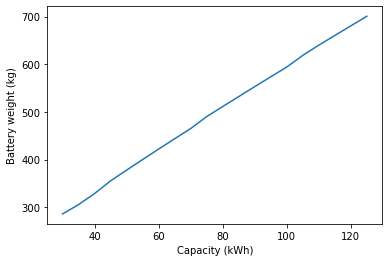

In [311]:
df_mc_all['battery pack'].plot()
plt.ylabel('Battery weight (kg)')
plt.xlabel('Capacity (kWh)')


## Update parameters and solve LCA in Brightway
The life cycle emissions for each design are calculated in Brightway for each battery design. This is relatively time consuming as the project parameters are updated for each battery design. A faster approach is presented in example 3 below. 


In [215]:
lcia_results_all = {}

#Calculate emissions for GWP100 ReCiPe midpoint V.1.13
cc = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method) and 'climate change' in str(method)]

#Update Brightway parameters for each battery system:
for battery_design in result_dict_all.keys():
    result_dict_all[battery_design]['brightway_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])
    battery = result_dict_all[battery_design]
    bat_lca.update_param_battery_bw(battery['brightway_parameters'])

    battery_production =bw.Database('battery_production').get(('025dcd4c91fc4eeda276f5fff9ad198e_copy5'))
    fu = {battery_production: battery['brightway_parameters']['battery_pack']}
    battery_lca = bw.LCA(fu, methods[2])
    battery_lca.lci()
    battery_lca.lcia()
    lcia_results_all [battery_design] = {}
    lcia_results_all [battery_design]['score'] = battery_lca.score
    lcia_results_all [battery_design]['unit'] = bw.Method(cc[0]).metadata['unit']
    lcia_results_all [battery_design]['capacity-kwh'] =battery['general_battery_parameters']['pack_energy_kWh']
    


## Results
The non-linear relation between the impact score and battery pack size is presented below (top figure). The non-linearity is caused by the increase in energy density due to pack scaling (bottom figure)

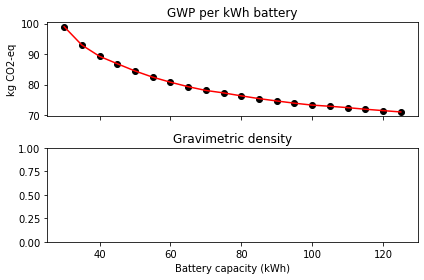

In [326]:
result_total = pd.DataFrame.from_dict(lcia_results_all)
emissions = list(result_total.loc['score']/result_total.loc['capacity-kwh'])
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].scatter(result_total.loc['capacity-kwh'], emissions,color='black')
ax[0].plot( result_total.loc['capacity-kwh'],emissions,color='r')
ax[0].set_ylabel('kg CO2-eq')
ax[1].set_xlabel('Battery capacity (kWh)')
ax[0].set_title('GWP per kWh battery')
ax[1].set_title('Gravimetric density')
plt.tight_layout()

# Modular LCA single battery (Example 3)
The iterative calculation of multiple battery designs by changing the parameters in Brightway is slow. Instead, a more efficient way is the use <br>
of precalculated gate-to-gate LCA modules based on https://link.springer.com/article/10.1007/s11367-015-1015-3. 

## Establish base product-module matrix ($A'$)
The base product-module matrix ($A'$) is a square matrix with all non battery production processes as defined in the Brightway 'cut_off_materials' database<br>
set to 1 kg and all battery-production processes set to 1 kg of battery (e.g. anode coating required for 1 kg of battery). 


In [69]:
# bat_lca.add_activity_parameters('cut_off_materials')

#First reset the cut-off activities and update all Brightway parameters for 1 battery.
bat_lca.update_param_battery_bw(battery_design_param)

# Cut off the exchanges if activity if present in the 'cut off database'. 
# E.g. 6um copper foil production is present in the 'cut of database' and will be cut in the anode coating process. All cut-off exchanges are set to zero
a = bat_lca.modules_with_cuts('cut_off_materials')

# Divide all battery production activities by total battery system weight:
bat_product_act = [act['name'] for act in bw.Database('battery_production')]
for act in bat_product_act:
    pack_weight = battery_design_param['battery_pack']
    a[act]['amount'] = a[act]['amount']/pack_weight
    for exc in a[act]['cuts'].keys():
        a[act]['cuts'][exc][1] = a[act]['cuts'][exc][1]/pack_weight
        
#Cut modules:
bat_lca.cut_modules_to_zero(a)

# Establish product-module dataframe of base system
A_prime=bat_lca.modular_technology_matrix(a)

A_prime

,anode electrode scrap handling,cell formation,anode current collector Cu (12um) production,cathode electrode scrap handling,Cobalt sulfate production,"market for copper, cathode",coated separator (9um+3um) production,anode current collector Cu (6um) production,market for manganese dioxide,"market group for electricity battery production, medium voltage",...,cathode current collector Al (17um) production,cathode active material (NMC532/50%/LMO-G) import,separator (9um) production,pack heater production,cathode current collector Al (13um) production,market for cobalt hydroxide,cathode current collector Al (18um) production,cathode calendering,cathode active material (NMC333) import,cathode active material (NMC622) import
anode electrode scrap,-1,0.000000,0.0,0,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0.0,0.0
cell,0,0.709912,0.0,0,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0.0,0.0
anode current collector Cu (12um),0,0.000000,1.0,0,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0.0,0.0
cathode electrode scrap,0,0.000000,0.0,-1,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0.0,0.0
Cobalt sulfate,0,0.000000,0.0,0,1.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cobalt hydroxide,0,0.000000,0.0,0,-0.652,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,1.0,0,0.000000,0.0,0.0
cathode current collector Al (18um),0,0.000000,0.0,0,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,1,0.000000,0.0,0.0
calendered cathode rolls,0,0.000000,0.0,0,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.345891,0.0,0.0
cathode active material (NMC333),0,0.000000,0.0,0,0.000,0,0.0,0.0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.000000,1.0,0.0


In [44]:
# modules_dict =a

# for module in modules_dict.keys():
#     if modules_dict[module]["cuts"]:
#         act = bw.get_activity(modules_dict[module]["key"])
#         cut_exchanges = [
#             exc
#             for exc in act.exchanges()
#             if exc["input"] in modules_dict[module]["cuts"].keys()
#         ]
#         for cut_exc in cut_exchanges:
#             try:  # Exchanges with formulas
#                 if cut_exc["formula"] is not None:
#                     cut_exc["amount"] = 0  # Amount to zero for cut-off modules
#                     cut_exc.save()
#             except KeyError:  # If exchange has no formula, set formula to amount
#                 print (cut_exc)
#                 # make new activity parameter:
#                 cut_exc["formula"] = cut_exc["amount"]
#                 cut_exc.save()
#                 bw.parameters.add_exchanges_to_group("my group", act)
#                 cut_exc["amount"] = 0
#                 cut_exc.save()


In [21]:
bat_lca.auto_add_parameter([act for act in bw.Database('cut_off_materials') if 'hydroxide' in act['name']][0].key)

In [15]:
for act in bw.Database('cut_off_materials'):
    bat_lca.parameterise_exchanges(act.key)

In [73]:
A_prime.shape

(115, 115)

In [74]:
A_prime.to_clipboard()

## Establish environmental impact matrix of modules ($H_m$)
Precalculation of each cut-off module

In [71]:
#Select all Recipe Midpoint impacts:
impacts = [m for m in bw.methods if 'ReCiPe Midpoint (H) V1.13' in str(m) and 'no LT' in str(m)]
H_m = bat_lca.lcia_modules (a, impacts)

Multiplication of the modular scaling factor ($s'$) with the modular emission matrix ($H_m$) to get the total emisions of the system ($h$). <br>
Scaling vector is calculated with the general LCA formula:<br>
$$s' = A'^{-1}y'$$
where $y'$ is the final demand vector.

In [72]:
pd.DataFrame(H_m[:,:].T,index=impacts, columns=A_prime.columns).to_clipboard()

(115, 18)

In [50]:
#Calculate for design 1:
pack_design =battery_design_param
#Parameter shortcuts:
pack_weight = battery_design_param['battery_pack']
capacity = battery_design_param['battery_capacity']

#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A_prime.values), A_prime.columns, A_prime.index)

#Establish final product demand vector for 1 battery based on pack weight
y_prime = pd.Series(data = 0, index=A_prime.index)
y_prime.loc['battery pack'] = pack_weight

#Calculate scaling vector:
s_prime = A_inv.dot(y_prime)


## Calculate total emissions of the system ($h$)

Multiplication of the scaling vector with the pre-calculated emissions of the modules:

$$h=s'H_m$$

In [51]:
# Emissions for all categories and modules:
h_all =  np.multiply(np.transpose([s_prime]),H_m)

Top 10 LCA modules with highest CO2-eq emissions:

In [52]:
df_h=pd.DataFrame(h_all[:,2],A_prime.columns, columns=[impacts[2]])
display(df_h.astype(int).sort_values(by=impacts[2], ascending=False).head(10)/capacity)

,"(ReCiPe Midpoint (H) V1.13 no LT, climate change, GWP100)"
"market for aluminium, wrought alloy",26.638889
anode active material (synthetic graphite) import,6.972222
"market group for electricity battery production, medium voltage",6.916667
"market for copper, cathode",6.750000
module electronics production,4.916667
cathode active material (LFP) import,4.666667
electrolyte (LFP) production,3.861111
market for lithium carbonate,3.611111
"market group for heat, district or industrial, natural gas",2.583333
market for lithium hydroxide,2.416667


Total GWP value:

In [75]:
df_h.sum()/capacity

(ReCiPe Midpoint (H) V1.13 no LT, climate change, GWP100)    77.785295
dtype: float64

Visualise emissions by module:

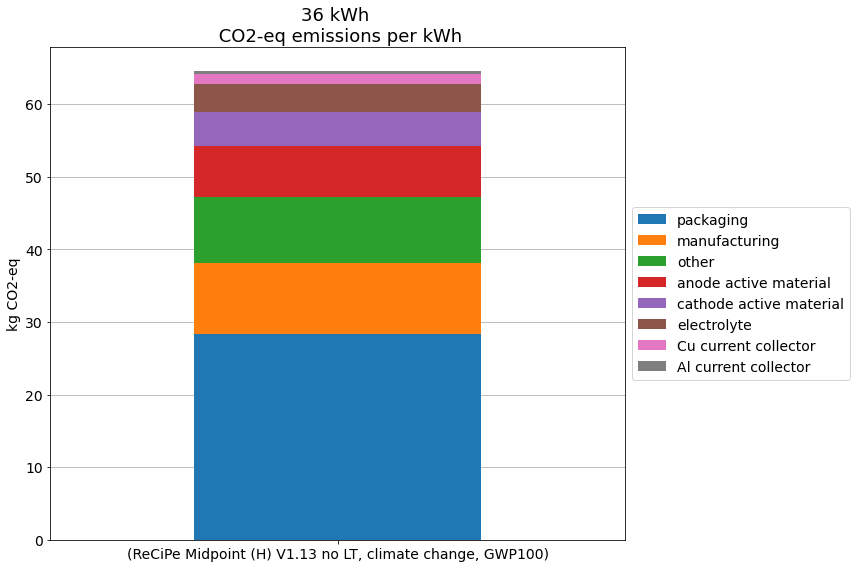

In [34]:
#Import process and product category mapping:
category_mapping=pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\process_product_type_contribution.xlsx", sheet_name='values').fillna(0)


def plot_module_impact (df_lcia_modules, df_category_mapping, title=None):
    """ Plot the impact of modules per module category"""
    df = df_category_mapping
    df.set_index('process', inplace=True)
    df=df.join(df_lcia_modules).groupby(['component category']).sum()
    category = df_lcia_modules.columns[0]
#     df.insert(loc=0, column='battery_system', value=lcia_modules)   
    df=df.sort_values(by=category, ascending=False)
    axes = df.T.plot.bar(stacked=True, legend=True, fontsize=14, figsize=(12,8), zorder=3)
    axes.grid(zorder=0, axis='y')
    axes.set_title(f'{title} \n CO2-eq emissions per kWh', fontsize=18)
    axes.set_ylabel('kg CO2-eq', fontsize = 14)
    axes.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



f = plot_module_impact(df_h/capacity,category_mapping, title=f'{round(capacity)} kWh')


## Modular LCA for multiple batteries


In [ ]:
battery = bd.Battery_system ( vehicle_type='EV', electrode_pair='NMC622-G', cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94).parameter_dictionary()
battery_designs_params=battery

In [ ]:
dict_result = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=battery, visible=False)

In [ ]:
# chemistry range
cath      = ['NMC333-G', 'NMC532-G','NMC622-G', 'NMC811-G','NCA-G','LFP-G','NMC532/50%/LMO  - G', 'LMO-G']
battery_designs_params = {}

# Establish a dictionary with a class of all battery designs:
for x in cath:
    name = f'{x} 23.5'
    battery = bd.Battery_system ( vehicle_type='EV', electrode_pair=x, cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94).parameter_dictionary()
    battery_designs_params[name]=battery

# Solve all battery systems in BatPaC.
result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=battery_designs_params, visible=False)

from tabulate import tabulate
headers = result_dict_all.keys()
data = [
        ['kWh', *[result_dict_all[pack]['general_battery_parameters']['pack_energy_kWh'] for pack in result_dict_all.keys()]]
       ]

for battery_design in result_dict_all.keys():
    battery = result_dict_all[battery_design]
    result_dict_all[battery_design]['brightway_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])

print(tabulate(data, headers=headers))


       NMC333-G 23.5    NMC532-G 23.5    NMC622-G 23.5    NMC811-G 23.5    NCA-G 23.5    LFP-G 23.5    NMC532/50%/LMO  - G 23.5    LMO-G 23.5
---  ---------------  ---------------  ---------------  ---------------  ------------  ------------  --------------------------  ------------
kWh             23.5             23.5             23.5             23.5          23.5          23.5                        23.5          23.5


In [ ]:
path_comp_type_linkage = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\component_type_linkage.xlsx"

df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

In [ ]:
result = result_dict_all['NMC333-G 23.5']['material_content_pack']

df_types['result'] = df_types.index.map(result).fillna(0)
df_types = df_types[(df_types != 0).all(1)]
df_types = df_types.groupby(['component_type', 'part_off']).sum()
df_types.sort_values(by='part_off', ascending=True, inplace=True)
df_types = df_types.reset_index(level=[1])

<AxesSubplot:>

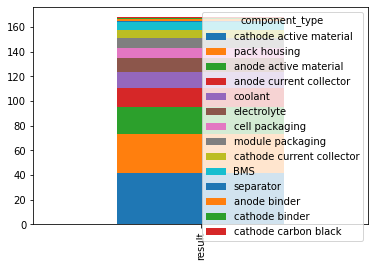

In [ ]:
df = df_types.drop('part_off', axis=1).sort_values(by='result', ascending=False)
df.T.plot.bar(stacked=True)

## Update parameter and activity formulas 

The activity and parameter formulas need to be calculcated for each battery design system. To improve the calculation speed, this is done outside of Brightway using the functions below. The Brightway formula strings are stored in a separate 

In [19]:
# 1. Calculate all formulas in the project parameters
import re

#Import all activity formulas:
func_df = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\bw_activity_functions.xlsx", sheet_name = 'activity_functions', index_col=[1,2])
func_dict = func_df.T.to_dict()

# Calculate and append parameters to dictionary (project parameters in Brightway):

def project_parameters_brightway ():
    """ Returns dictionary with amount and formula of the Brightway project parameter"""
    project_param_dict = {}
    for param in ProjectParameter:
        if param.formula is None:
            param.formula=0
        project_param_dict[param.name] = {'amount':param.amount, 'formula':param.formula}
    return project_param_dict

def update_project_parameter_amount (project_param_dict,design_dict):
    """ Update the 'amount' in the Brightway project parameter dictionary based on battery design"""        
    for param in design_dict['design_parameters'].keys():
        project_param_dict[param]['amount'] = design_dict['design_parameters'][param]
    return project_param_dict


def update_project_parameter_formulas (project_parameters_formulas):
    """ Calculates the project parameter formulas recursively.
    
    Args:
        project_parameters_dict (dict): dictionary with Brightway project parameters
        
    Return:
        dictionary with parameter name (key) and amount (value)
    """
    param_dict_2= {a:b['amount'] for a, b in project_parameters_formulas.items() if b['formula'] == 0}
    for param in project_parameters_formulas.keys():
        if project_parameters_formulas[param]['formula'] != 0:
            
            def calc_amount_formula(param,param_dict_2):
                """ Recursive function, calls itself if parameter name in project formula is based on a different formula"""
                try:
                    amount=eval(project_parameters_formulas[param]['formula'], param_dict_2)
                    return amount
                except NameError as Argument:
                    param_error = re.split("['']", str(Argument))[1]
                    amount = calc_amount_formula(param_error,param_dict_2 )
                    param_dict_2[param_error] = amount
                    amount = calc_amount_formula (param, param_dict_2)
                    return amount
            amount = calc_amount_formula(param,param_dict_2)    
            project_parameters_formulas[param]['amount'] = amount
            param_dict_2[param] = amount
    param_dict_amount = {a:b['amount'] for a, b in project_parameters_formulas.items()}
    return param_dict_amount


def get_project_parameters_dict (design_dict):
    """ Returns a dictionary of the Brightway project parameters based on design parameter amounts
    and calculated project formulas
    
    Args:
        design_dict [dict]: design parameters
        
    Return:
        dict: parameter name and amount    
    """
    project_param_dict = project_parameters_brightway()
    #update 'amount' in project parameter based on design dictionary:
    project_param_dict_update = update_project_parameter_amount(project_param_dict, design_dict)        
    #Update project parameters with formulas:
    parameter_dictionary =  update_project_parameter_formulas(project_param_dict_update)  
    
    return parameter_dictionary



def update_module_formulas (design_dict, activity_functions):
    """ Updates parameterised modules based on activity formalas and project parameters 
    
    Args:
        project_parameters (dict): Brightway project parameter values 
        activity_functions (dict): Brightway activity fucntions
        
    Returns:
        Dictionary with updated activity amounts
    """
    output_dict = {}

    parameter_dictionary = get_project_parameters_dict (design_dict)
    
    # Upate all activity formulas based on project parameters:
    for key in activity_functions.keys():
        
        if activity_functions[key]['material_group'] == 'reference product': 
            #Output/reference product is positive
            amount = eval(activity_functions[key]['formula'], parameter_dictionary)   
        else: 
            #Input is negative
            amount = -eval(activity_functions[key]['formula'], parameter_dictionary)
        output_dict[key] = amount 
    return output_dict

  

def update_parameterised_modules (technology_matrix_base, battery_design_dict, activity_functions_dict):
    """ Updates modules based on functions with design specific parameters
    
    Args:
        technology_matrix_base (df): base product-module matrix (A_prime)
        battery_design_dict (dict): dictionary of activity project parameters        
        activity_functions (dict): dictionary of parameterised modules (based on functions) including 
    
    Return:
        df: updated square product-module matrix
    """

    updated_act = update_module_formulas(battery_design_dict, activity_functions_dict)
    battery_weight = battery_design_dict['brightway_parameters']['battery_pack']
    A_matrix = technology_matrix_base.copy(deep=True) # To make sure the default A dataframe is not modified
    bat_product_act = [act['name'] for act in bw.Database('battery_production')]

    for idx in A_matrix.index:
        for col in A_matrix.columns:
            if (col, idx) in updated_act.keys() and col in bat_product_act:
                A_matrix.loc[idx, col] = updated_act[(col, idx)]/battery_weight
            elif  (col, idx) in updated_act.keys():
                A_matrix.loc[idx, col] = updated_act[(col, idx)]    
    return A_matrix





## Calculate emissions and visualise results

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

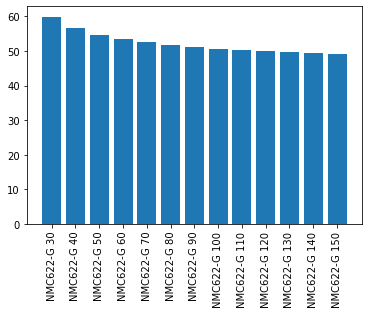

In [45]:
total_emission_kwh = []
module_emissions = {}

for key in result_dict_all.keys():
    
    capacity = result_dict_all[key]['brightway_parameters']['battery_capacity']
    pack_weight = result_dict_all[key]['brightway_parameters']['battery_pack']
    A_prime_temp = update_parameterised_modules(A_prime,result_dict_all[key], func_dict)
    
    #Inverse the A' matrix:
    A_inv = pd.DataFrame(np.linalg.pinv(A_prime_temp.values), A_prime_temp.columns, A_prime_temp.index)

    #Establish final product demand vector for 1 battery based on pack weight
    y_prime = pd.Series(data = 0, index=A_prime_temp.index)
    y_prime.loc['battery pack'] = pack_weight

    #Calculate scaling vector:
    s_prime = A_inv.dot(y_prime)
    # GWP100:
    emission = H_m[:,2]*s_prime
    module_emissions[key]=emission

    total_emission_kwh.append(emission.sum()/capacity)
    
#Plot total emissions
plt.bar(result_dict_all.keys(), total_emission_kwh)
plt.xticks( rotation='vertical')



Text(0, 0.5, 'GWP100 impact [kg CO2-eq]')

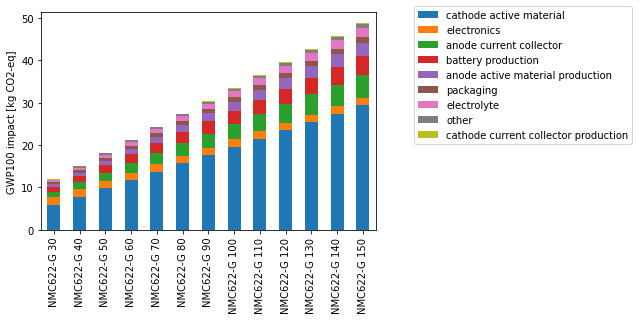

In [49]:
category_mapping=pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\process_product_type_contribution.xlsx", sheet_name='values').fillna(0)
category_mapping.set_index('process', inplace=True)

       
df = category_mapping.groupby(['aggregated']).sum()


for key in module_emissions.keys():

        df_module_emission = pd.DataFrame(module_emissions[key])
        df_temp =category_mapping.join(df_module_emission).groupby(['aggregated']).sum()
        df[key]=df_temp

        

ax=(df/capacity).sort_values(by=list(result_dict_all.keys())[0], ascending=False).T.plot.bar(stacked=True)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('GWP100 impact [kg CO2-eq]')


In [51]:
openpyxl.load_workbook(r'3_MC_battery_pack_material.xlsx')

# calculate battery design

In [ ]:
import itertools
from tqdm.notebook import tqdm

cath      = ['NMC333-G', 'NMC532-G','NMC622-G', 'NMC811-G','NCA-G','LFP-G','NMC532/50%/LMO  - G']
ano       = ['synthetic', 'natural']
sil       = [0.0,0.08]
cell_mod  = [12,34]  # Based on min and max values in BatPaC
energy    =  [75]
battery_designs_params = {}
count = 0
for cat, an, si, cell, ene in tqdm(itertools.product(cath, ano, sil, cell_mod, energy)):
#     print (count, cat, an, si, cell, ene)

    
    battery = bd.Battery_system ( vehicle_type='EV', electrode_pair=cat, 
                                            silicon_anode= si, pack_energy = ene, graphite_type=an,cells_per_module=cell ).parameter_dictionary()
    count +=1

    battery_designs_params[count]=battery

# result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=battery_designs_params, visible=False)


0it [00:00, ?it/s]

In [ ]:
result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=battery_designs_params, visible=True)


In [ ]:
#Establish correpsonding processs emissions matrix H:

df_emission = pd.DataFrame(impact_all, index=A.columns, columns=impacts).T

In [53]:
def calculate_modular_A (technology_matrix_default, pre_calculated_modules, battery_design_dictionary, name,  production_act, reference_prod):  
    
    updated_act = update_formulas(battery_design_dictionary)
    battery_weight = battery_design_dictionary['brightway_parameters']['battery_pack']
    capacity = battery_design_dictionary['brightway_parameters']['battery_capacity']
    A_matrix = technology_matrix_default.copy(deep=True) # To make sure the default A dataframe is not modified
    h = pre_calculated_modules.copy(deep=True) 
    
    
    # Establish A frame for battery production. Production processes and process outputs (reference products) have unique name, except battery pack
    for idx in A_matrix.index:
        for col in A_matrix.columns:
            if (col, idx) in updated_act.keys() and col in production_act:
                A_matrix.loc[idx, col] = updated_act[(col, idx)]
            elif  (col, idx) in updated_act.keys():
                A_matrix.loc[idx, col] = updated_act[(col, idx)]
                
    #Battery pack in unit, not kg:
    A_matrix.loc['battery pack', 'module and pack assembly']=1
     
    #Unique name for battery production processes and products:
    bat_product_act_unique = [act +f' {name}' for act in production_act]
    reference_prod_unique = [product+f' {name}' if product !='battery pack' else product for product in reference_prod]
    new_act_names = dict(zip(production_act,bat_product_act_unique))
    new_prod_names = dict(zip(reference_prod, reference_prod_unique))
    
    A_matrix.rename(columns=new_act_names, inplace=True)
    A_matrix.rename(index=new_prod_names, inplace = True)
    h.rename(columns=new_act_names, inplace=True)    
    return A_matrix[bat_product_act_unique], h[bat_product_act_unique]

In [ ]:
# Calculate all process parameters for specfici design:
#Get battery production activities and reference products:
production_act = []
reference_prod  = []
for act in bw.Database('battery_production'):
    production_act.append(act['name'])
    for exc in act.exchanges():
        if exc['type'] == 'production':
            reference_prod.append(bw.get_activity(exc['input'])['reference product'])


A_wo_production = A.drop(production_act, axis=1).drop(reference_prod)
h_wo_production = df_emission.drop(production_act, axis=1)

list_df_A = []
list_df_h = []
for x in result_dict_all.keys():
    df_A, df_h = calculate_modular_A(A,df_emission,result_dict_all[x], x, production_act,reference_prod )
    list_df_A.append(df_A)
    list_df_h.append(df_h)
prod_df = pd.concat(list_df_A, axis=1).fillna(0)
h_array = pd.concat(list_df_h, axis=1)
A_non_square = pd.concat([prod_df,A_wo_production], axis=1).fillna(0)
h_non_square = pd.concat([h_array, h_wo_production], axis=1).fillna(0)


In [11]:
df.to_excel('3_PAR_battery_design_parameters.xlsx')

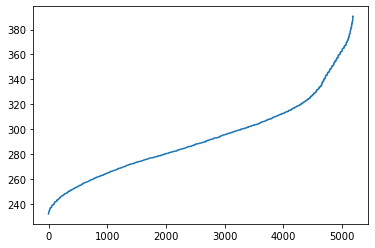

In [18]:
import pickle

a = {'hello': 'world'}

# with open(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\50_battery.pickle', 'wb') as handle:
#     pickle.dump(result_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\battery_all.pickle', 'rb') as handle:
    result_dict_all = pickle.load(handle)

weight = []

for x in result_dict_all.keys():
    weight.append(result_dict_all[x]['material_content_pack']['battery pack'])
    
weight.sort()
plt.plot(weight)

In [12]:
for battery_design in result_dict_all.keys():
    battery = result_dict_all[battery_design]
    result_dict_all[battery_design]['design_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])

In [ ]:
A_non_square.to_csv(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\4_upi_non_square.csv')
h_non_square.to_csv(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\4_pe_non_square.csv')

In [37]:
charging_time = list(range(5,42,1))

bat_dict_all = {}
count = 0
for time in charging_time:
    #Establish battery system class of specific design:
    battery = bd.Battery_system ( vehicle_type='EV', electrode_pair='NMC622-G', cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=84, available_energy=94, sep_foil_thickness=9, sep_coat_thickness=3, max_charging_time=time)
    bat_dict_all[count] = battery.parameter_dictionary()
    count+=1

    
result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=bat_dict_all, visible=False)


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [03:24<00:00,  5.52s/it]


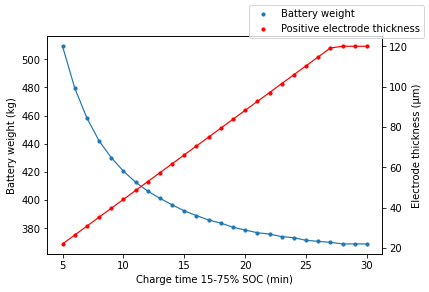

In [94]:
with open(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Appendix_data\charging_time_sensitivity.pickle', 'rb') as handle:
    result_dict_all = pickle.load(handle)
charging_time = list(range(5,42,1))

pack_weight = []
electrode = []

for k,v in result_dict_all.items():
    electrode.append(v['general_battery_parameters']['positive_electride_thickness'])
    pack_weight.append(v['material_content_pack']['battery pack'])


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(charging_time[0:41-15], pack_weight[0:41-15], label='Battery weight', s=10)
ax1.plot(charging_time[0:41-15], pack_weight[0:41-15], linewidth=1.2)

ax2.scatter(charging_time[0:41-15], electrode[0:41-15], c='r', label='Positive electrode thickness', s=10)
ax2.plot(charging_time[0:41-15], electrode[0:41-15], c='r', linewidth=1.2)

ax1.set_ylabel('Battery weight (kg)')
ax2.set_ylabel ('Electrode thickness (μm)')
ax1.set_xlabel ('Charge time 15-75% SOC (min)')
fig.legend()

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]